<a href="https://colab.research.google.com/github/DarrrkS/BEST.WEB2021/blob/main/LR4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from IPython.core.pylabtools import figsize
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
figsize(40,20)

url = 'https://drive.google.com/u/0/uc?id=1-TzMGAKLjS9RrYXSBWCAD0zAk-gd1pab&export=download'
data = pd.read_csv(url)


Функция для построения графика



In [ ]:
def plot_features_coefs(x, y):
  fig = plt.figure(figsize=(15, 15))
  ax = fig.add_subplot(111)
  ax.bar(x, height=y, label='Вклад признаков')
  ax.tick_params(axis='x', which='major', rotation=45)
  plt.legend()
  plt.show()

Как и в прошлый раз проверим на наличие дубликатов:

In [ ]:
data[data.duplicated(keep='first')]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1563,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1564,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1567,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1581,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


Удалим дубликаты, как и раньше

In [ ]:
print('Строк до: ', len(data))
data.drop_duplicates(keep='first', inplace=True)
print('Строк после: ',len(data))

Строк до:  1599
Строк после:  1359


Разделим данные для обучения и проверки

In [ ]:
X_columns = data.columns[:-1]
y_column = data.columns[-1]
X = data[X_columns]
y = data[y_column]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

Почистим от коррелирующих признаков

In [ ]:
X_train.drop(['citric acid', 'density', 'pH', 'total sulfur dioxide'], axis = 'columns', inplace=True)
X_test.drop(['citric acid', 'density', 'pH', 'total sulfur dioxide'], axis = 'columns', inplace=True)
X_columns = X_train.columns[:-1]

Заранее применим метод оверсэмплинга из ЛР2

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm,y_sm)

# Дерево решений

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=17)
tree_clf.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(random_state=17)

In [ ]:
print(f"Дерево решений: {tree_clf.score(X_test_sm, y_test_sm)}")
print(f"Проверим несостоятельность одиночного дерева, если результат единица, значит произошло переобучение: {accuracy_score(y_train_sm, tree_clf.predict(X_train_sm))}")

Дерево решений: 0.73094688221709
Проверим несостоятельность одиночного дерева, если результат единица, значит произошло переобучение: 1.0


# Рандомный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

In [ ]:
rf_acc = accuracy_score(y_test_sm, rf.predict(X_test_sm))
print(f"Случайный лес: {rf_acc}\n")

Случайный лес: 0.8406466512702079



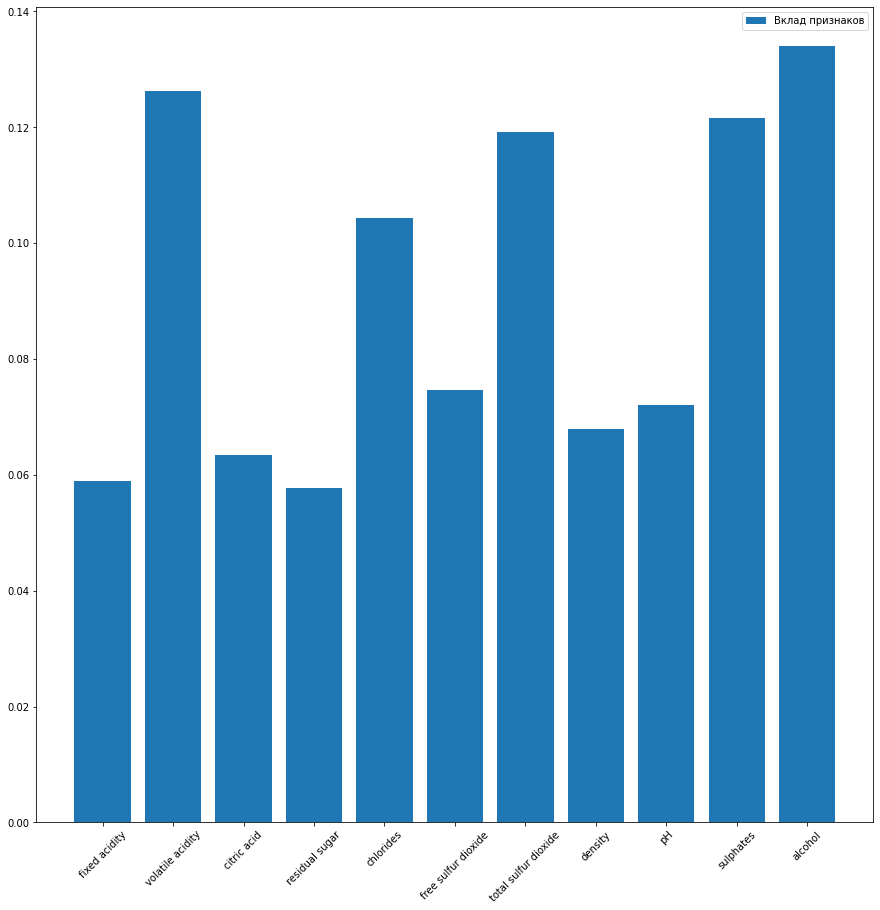

In [ ]:
plot_features_coefs(X_test_sm.columns, rf.feature_importances_)

Наиболее важными признаками являются alcohol, sulphates, volatile acidity

# Сравнение результатов с использованием кросс-валидации и без нее

Используем кросс-валидацию

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
rf = RandomForestClassifier(n_estimators=300, random_state=42)
res = cross_val_score(rf, X_train_sm, y_train_sm, cv=5)
print(res.max())

0.8169556840077071


Не используем кросс-валидацию

In [ ]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_sm, y_train_sm)
sc = rf.score(X_test_sm, y_test_sm)
print(sc)

0.8521939953810623


Используя кросс валидацию результат лучше

# Градиентный бустинг

Установим catboost от Яндекса

In [ ]:
!pip install catboost

Проведем обучение

In [ ]:
%%time
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import numpy as np

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)): 
        p = CatBoostRegressor(n_estimators=n_trees, max_depth=depth).fit(X_train_sm, y_train_sm).predict(X_test_sm)
        scores[i, j] = mean_squared_error(y_test_sm, p)

Learning rate set to 0.5
0:	learn: 1.2786694	total: 1.14ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.2229790	total: 1.55ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.1727026	total: 2.14ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.1671651	total: 2.92ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.1637301	total: 4.29ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.1627982	total: 6.58ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.1402909	total: 11ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.1396176	total: 25ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.1403966	total: 31.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.1456066	total: 63.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 1.2786694	total: 1.04ms	remaining: 11.5ms
1:	learn: 1.0610641	total: 2.29ms	remaining: 11.4ms
2:	learn: 0.9524522	total: 3.53ms	remaining: 10.6ms
3:	learn: 0.8944931	total: 4.78ms	remaining: 9.55ms
4:	learn: 0.8634835	total: 5.98

Проиллюстрируем улучшение работы, от увеличения глубины деревьев

In [ ]:
from ast import increment_lineno
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
for i in range(scores.shape[0]):
  plt.plot(np.linspace(1,100,10),scores[i], label='depth=' + str(np.arange(2,12)[i]))
  plt.legend()

Проверим среднеквадратичную ошибку у случайного леса

In [ ]:
%%time

from sklearn.ensemble import RandomForestRegressor

linear_preds = RandomForestRegressor().fit(X_train_sm, y_train_sm).predict(X_test_sm)
res5 = mean_squared_error(y_test_sm, linear_preds) ** 0.5
print(res5)

Градиентный бустинг уменьшает среднюю квадратиную ошибку

In [ ]:
%%time
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import numpy as np

scores = np.ndarray([10, 10])
for i, n_trees in enumerate(np.linspace(1, 100, 10)):
    for j, depth in enumerate(np.arange(2, 12)):
        p = CatBoostRegressor(n_estimators=n_trees, max_depth=depth, task_type="GPU").fit(X_train_sm, y_train_sm).predict(X_test_sm)
        scores[i, j] = mean_squared_error(y_test_sm, p)